In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00


In [4]:
import optuna
import torch
import pandas as pd
from optuna.trial import TrialState
from optuna.samplers import TPESampler

In [5]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torch.utils.data import TensorDataset

In [ ]:
from ANN_utility.Utils import seed_everything
from ANN_utility.ANN import Net
from ANN_utility.model_pipeline import model_pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from ANN_utility.Data_preprocess import Data_preprocess

In [6]:
!pip install statannotations

In [7]:
!pip install statannot

In [8]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu, normaltest, wilcoxon
from statannot import add_stat_annotation


def seed_everything(seed):
    #Ensuring reproducible of training
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def visualize_training_curve(training_loss, validation_loss, training_f1, validation_f1, training_ap, validation_ap, epochs, name_curve):
    sns.set(style = "whitegrid")
    num_epochs = range(1, epochs + 1)
    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5), dpi=600)
    plt.plot(num_epochs, training_loss, label='Training Loss', linewidth=1)
    plt.plot(num_epochs, validation_loss, label='Validation Loss', linewidth=1)
    plt.plot(num_epochs, training_f1, label='Training f1 score', linewidth=1)
    plt.plot(num_epochs, validation_f1, label='Validation f1 score', linewidth=1)
    plt.plot(num_epochs, training_ap, label='Training AP', linewidth=1)
    plt.plot(num_epochs, validation_ap, label='Validation AP', linewidth=1)

    # Setting style for labels
    plt.title(name_curve, fontsize=16,fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    #plt.savefig("/content/drive/MyDrive/1_PROJECTS/D18/2. Chương/ALK/Chốt kết quả/ANN/training_history_test.png", bbox_inches='tight',dpi = 1200)
    plt.show()



def compare_opt_boxplot(baseline, optimize, metric, fig_name, save_path):
    AUC_internal = pd.DataFrame({"Baseline":baseline,
                     "Tune":optimize})


    df_melt = pd.melt(AUC_internal.reset_index(), id_vars=['index'], value_vars=AUC_internal.columns)
    df_melt.columns = ['index', 'Model', metric]
    subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)

    stat_results = [wilcoxon(AUC_internal['Baseline'].astype('float'), AUC_internal['Tune'].astype('float'), alternative="two-sided"),
                    # wilcoxon(AUC_internal['PS'].astype('float'), AUC_internal['SS'].astype('float'), alternative="two-sided"),
                    # wilcoxon(AUC_internal['SS'].astype('float'), AUC_internal['GS'].astype('float'), alternative="two-sided"),
                    # wilcoxon(AUC_internal['GS'].astype('float'), AUC_internal['FS'].astype('float'), alternative="two-sided")
                   ]

    pvalues = [result.pvalue for result in stat_results]
    plotting_parameters = {
        'data':    df_melt,
        'x':       'Model',
        'y':       metric,
        'palette': subcat_palette[1:]
    }

    pairs = [('Baseline', 'Tune'),
             # ('PS', 'SS'),
             # ('SS', 'GS'),
             # ('GS', 'FS')
            ]


    sns.set_style("whitegrid")
    plt.figure(figsize = (10,7))

    my_colors = {'Tune': 'salmon',
                 # 'PS': 'orange',
                 # 'SS': 'lightgreen',
                 # 'GS': 'lightblue',
                 'Baseline': 'lightgreen'}


    ax = sns.boxplot(x='Model', y=metric, data=df_melt, palette=my_colors, showmeans=True ,meanprops={"marker":"d",
                               "markerfacecolor":"white",
                               "markeredgecolor":"black",
                              "markersize":"5"})

    mean = round(AUC_internal.mean(),3)
    data = np.array(mean)
    ser = pd.Series(data, index =AUC_internal.columns)

    dict_columns = {'Mean':mean,}
    df = pd.DataFrame(dict_columns)

    vertical_offset = df["Mean"].median()*0.008

    for xtick in ax.get_xticks():
        ax.text(xtick,ser[xtick]+ vertical_offset,ser[xtick],
        horizontalalignment='center',color='k',weight='semibold', fontsize = 15)


    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.configure(text_format="simple")
    annotator.set_pvalues_and_annotate(pvalues)

    ax.set_ylabel(metric, fontsize = 12)
    ax.set_xlabel(None)
    ax.set_xticklabels(labels = AUC_internal.columns, fontsize = 12)
    ax.set_title(fig_name,fontsize = 16, weight ='semibold')

    plt.savefig(save_path, dpi = 600)
    plt.show()

In [9]:
class Net(torch.nn.Module):
    def __init__(self,params):
        super(Net,self).__init__()
        #n_layers
        self.n_layers_mlp = params["n_layers_mlp"]
        # dense_neurons
        self.dense_neurons = params["dense_neurons"]

        self.mlp_layers = torch.nn.ModuleList([])
        for i in range(self.n_layers_mlp):
            if i == 0:
                intput = params["in_features"]
                output = self.dense_neurons
            elif i != self.n_layers_mlp - 1:
                intput =  int(self.dense_neurons/(2**(i-1)))
                output = int(self.dense_neurons/(2**(i)))
            else:
                intput = int(self.dense_neurons/(2**(i-1)))
                output = 1
            self.mlp_layers.append(Linear(intput, output))

    def forward(self,x,params):
        rate = params["rate"]
        x = x.view(x.size(0), -1) # Flatten the input tensor for the first layer
        for i in range(self.n_layers_mlp):
            if i != self.n_layers_mlp-1:
                x = torch.relu(self.mlp_layers[i](x))
                x = F.dropout(x, p=rate, training=self.training)
            else:
                x =  torch.sigmoid(self.mlp_layers[i](x))

        return x

In [10]:
from sklearn.metrics import f1_score, average_precision_score, classification_report
import random
from sklearn.model_selection import RepeatedStratifiedKFold

In [11]:
class model_pipeline():
    '''
    This class contains a training pipeline including:training, evaluating and cross validation.
    Input:
    ------
    model architecture, data loader, optimizer, loss function, parameters for training model

    Returns:
    --------
    Trained model and training curve
    '''
    def __init__(self,model,params, criterion, optimizer,epochs,train_loader=None, valid_loader=None, seed=42, device=torch.device("cpu"),
                 save_dir=".", show_progress = True):
        self.device = device
        self.params = params
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.seed  = seed
        self.save_dir = save_dir
        self.epochs = epochs
        self.show_progress = show_progress
        self.seed_everything()

    def seed_everything(self):
        #Ensuring reproducible of training
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


    def train(self):
        #Training
        #self.seed_everything()
        self.model.train()
        trainning_loss = 0
        truelabels = []
        probas = []
        proba_flat = []
        pred_flat = []
        for fps, labels in self.train_loader:
            #Optimizer
            self.optimizer.zero_grad()
            output = self.model(fps, self.params)

            #Loss function
            loss = self.criterion(output[:,0], labels)
            loss.backward()
            self.optimizer.step()
            trainning_loss += loss.item()

            probas.append(np.asarray(output.detach().cpu()))
            a = list(np.asarray(labels.detach().cpu()))
            truelabels.append(a)


        #Flatten prediction array
        for i in probas:
            for j in i:
                proba_flat.append(j)

        pred_flat = proba_flat.copy()
        for key, value in enumerate(proba_flat):
            if value < 0.5:
                pred_flat[key] = 0
            else:
                pred_flat[key] = 1
        flatten_list = lambda truelabels:[element for item in truelabels for element in flatten_list(item)] if type(truelabels) is list else [truelabels]
        truelabels = flatten_list(truelabels)

        #Calculating loss, f1, average precision for training set
        loss = trainning_loss/len(self.train_loader)
        f1 = f1_score(truelabels,pred_flat)
        ap = average_precision_score(truelabels,proba_flat)
        return loss, f1, ap

    def evaluate(self):
        #Evaluate model
        self.model.eval()
        validation_loss = 0
        truelabels_val = []
        probas_val = []
        proba_flat_val = []
        pred_flat_val = []
        with torch.no_grad():
            for fps, labels in self.valid_loader:
                out_put = self.model(fps, self.params)
                validation_loss += self.criterion(out_put[:,0], labels).cpu()

                probas_val.append(np.asarray(out_put.detach().cpu()))
                a = list(np.asarray(labels.detach().cpu()))
                truelabels_val.append(a)

        #Flatten prediction
        for i in probas_val:
            for j in i:
                proba_flat_val.append(j)

        pred_flat_val = proba_flat_val.copy()
        for key, value in enumerate(proba_flat_val):
            if value < 0.5:
                pred_flat_val[key] = 0
            else:
                pred_flat_val[key] = 1


        flatten_list = lambda truelabels_val:[element for item in truelabels_val for element in flatten_list(item)] if type(truelabels_val) is list else [truelabels_val]
        truelabels_val = flatten_list(truelabels_val)

        #Calculation metrics: validation loss, f1 score and average precision
        loss_val = validation_loss/len(self.valid_loader)
        f1_val = f1_score(truelabels_val,pred_flat_val)
        ap_val = average_precision_score(truelabels_val,proba_flat_val)
        return loss_val, f1_val, ap_val


    def save_model(self):
        #Saving model into *pth file in provided saving directory
        print("Saving...")
        torch.save({
                'epoch': self.epochs,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss': self.criterion,
                }, self.save_dir)

    def fit(self):
        self.seed_everything()
        self.history = {"train_loss":[], "val_loss": [],
              "train_f1":[], "val_f1":[],
              "train_ap":[], "val_ap":[]}
        for epoch in range(self.epochs):
            train1_loss, train1_f1, train1_ap = self.train()

            val1_loss,val1_f1, val1_ap = self.evaluate()

            #self.lr_scheduler.step(train1_f1)
            self.history["train_loss"].append(train1_loss)
            self.history["val_loss"].append(val1_loss.detach().numpy())
            self.history["train_f1"].append(train1_f1)
            self.history["val_f1"].append(val1_f1)
            self.history["train_ap"].append(train1_ap)
            self.history["val_ap"].append(val1_ap)
            if self.show_progress == True:
                if (epoch+1) % 5 == 0:
                    print("Epoch: {}/{}.. ".format(epoch+1, self.epochs),
              "Training Loss: {:.3f}.. ".format(train1_loss),
              "validation Loss: {:.3f}.. ".format(val1_loss),
            "validation f1_score: {:.3f}.. ".format(val1_f1),
                  "validation average precision: {:.3f}.. ".format(val1_ap),
             )
            else:
                pass


        if self.show_progress == True:
            self.visualize()
        else:
            pass
        self.save_model()
        print("Complete the process...")


    def visualize(self):
        sns.set()

        # create a subplot with three axes
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))


        ax1.plot(self.history["train_loss"], label='Training Loss')
        ax1.plot(self.history["val_loss"], label='Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.set_title('Training and Validation Loss over Epochs')

        ax2.plot(self.history["train_f1"], label='Training F1 Score')
        ax2.plot(self.history["val_f1"],label="Validation F1 Score")
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('F1 score')
        ax2.legend()
        ax2.set_title('F1 Score over Epochs')

        ax3.plot(self.history["train_ap"], label='Training AP Score')
        ax3.plot(self.history["val_ap"],label="Validation AP Score")
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Average precision score')
        ax3.legend()
        ax3.set_title('Average precision Score over Epochs')

        fig.suptitle('Training Metrics over Epochs')


        plt.show()

    def reset_weights(self,model):

        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()


    def cross_val_score(self, X, y,model, cv,batch_size, device,verbose = True):
        #Splitting original dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state =42, stratify=y)
        self.seed_everything()
        self.History = {"F1_record":[],"AP_record":[]}

        for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):

            Xtrain = torch.tensor(X_train.iloc[train_index,:].values , device=self.device).float()
            Xtest = torch.tensor(X_train.iloc[test_index,:].values, device=self.device).float()

            ytrain = torch.tensor(y_train.iloc[train_index].values , device=self.device).float()
            ytest = torch.tensor(y_train.iloc[test_index].values, device=self.device).float()

            train_dataset = TensorDataset(Xtrain, ytrain)
            test_dataset = TensorDataset(Xtest, ytest)

            self.train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
            self.valid_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)
            #self.seed_everything()
            self.model = model.to(self.device)
            self.model.apply(lambda m: self.reset_weights(m))


            for epoch in range(self.epochs):
                train1_loss,train1_f1, train1_ap = self.train()
            val1_loss,val1_f1, val1_ap = self.evaluate()

            if verbose == True:
                print("Fold: {}.. ".format(i+1),
                "validation f1_score: {:.3f}.. ".format(val1_f1),
                      "validation average precision: {:.3f}.. ".format(val1_ap),
                 )
            else:
                pass
            self.History["F1_record"].append(val1_f1)
            self.History["AP_record"].append(val1_ap)

        self.mean_scores_ap = sum(self.History["AP_record"]) / len(self.History["AP_record"])
        print(f"Overall AP score = {self.mean_scores_ap :.4f}")
        self.mean_scores_f1 = sum(self.History["F1_record"]) / len(self.History["F1_record"])
        print(f"Overall F1 score = {self.mean_scores_f1:.4f}")

In [12]:
class Data_preprocess():
    """
    This class converts numerical activity values to binary values and splits the original dataset into training, validation, and test tensor d   datasets. Additionally, it creates a data loader for each of the split datasets.

    Input:
    ------
    file csv, activity threshold, activiy column's name, device (GPU or CPU), batch size

    Returns:
    --------
    Tensor splitted dataset, data loader
    """
    def __init__(self, path, y_name,threshold, col_drop, device, batch_size):
        self.path = path
        self.data = pd.read_csv(self.path)
        self.data = self.data.drop(col_drop,axis=1)
        self.Y_name = y_name
        self.device = device
        self.batch_size = batch_size
        self.threshold = threshold

    def target_bin(self,data):
        #Converting numerical values to binary values
        t1 = data[self.Y_name] < self.threshold
        data.loc[t1, self.Y_name] = 0
        t2 = data[self.Y_name] >= self.threshold
        data.loc[t2, self.Y_name] = 1
        data[self.Y_name] = data[self.Y_name].astype('int64')
        return data

    def create_dataloader(self,data):
        X = data.drop(data.columns[0],axis = 1)
        y = data[self.Y_name]


        #Split Data train, Data_test, Data_validation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                                        random_state =42, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1,
                                                                        random_state =42, stratify=y_train)


        # change numpy to tensor gpu
        self.X_train = torch.tensor(X_train.values , device= self.device).float()
        self.X_val = torch.tensor(X_val.values , device= self.device).float()
        self.X_test = torch.tensor(X_test.values, device= self.device).float()

        self.y_train = torch.tensor(y_train.values , device=self.device).float()
        self.y_val = torch.tensor(y_val.values, device=self.device).float()
        self.y_test = torch.tensor(y_test.values, device=self.device).float()

        # convert into dataloader
        self.train_dataset = TensorDataset(self.X_train, self.y_train)
        self.val_dataset = TensorDataset(self.X_val, self.y_val)
        self.test_dataset = TensorDataset(self.X_test, self.y_test)

        self.train_loader = torch.utils.data.DataLoader(dataset=self.train_dataset,
                                                  batch_size=self.batch_size,
                                                  shuffle=True)
        self.valid_loader = torch.utils.data.DataLoader(dataset=self.val_dataset,
                                                  batch_size=self.batch_size,
                                                  shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=self.test_dataset,
                                                  batch_size=self.batch_size,
                                                  shuffle=False)


    def fit(self):
        self.data_bin = self.target_bin(self.data)
        self.create_dataloader(self.data_bin)

In [13]:
#Objective function returns f1 score value in cross validation test
def objective(trial):
    #Define searching space
    params_space ={"in_features" : 2048,
         "n_layers_mlp" : trial.suggest_int("n_layers_mlp", 2,6),
         "dense_neurons":  trial.suggest_int("dense_neurons", 128,2048),
               "epochs": trial.suggest_int("epochs", 50,100),
         "rate":trial.suggest_float("rate", 0.1, 0.8)}


    device = torch.device("cpu")
    model_tune = Net(params_space).to(device)
    optimizer = torch.optim.Adam(model_tune.parameters(), lr= 0.0001, weight_decay = 0.01)
    criterion = torch.nn.BCELoss()
    save_dir = "/content/drive/MyDrive/ANN/ANN_model_tune.pth"

    pip = model_pipeline(model = model_tune, params = params_space, criterion = criterion, optimizer = optimizer,
                    epochs = params_space["epochs"], seed = 42, device = device, save_dir  = save_dir)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=42)
    #Define X_train and y_train
    preprocess = Data_preprocess(path = "/content/drive/MyDrive/Thiazole project/Data for Training Model/ECPF4.csv", y_name = "pChEMBL Value",
                             threshold = 7, col_drop = "Smiles",
                             device = device, batch_size = 32)
    preprocess.fit()
    X_train = preprocess.data_bin.drop(preprocess.data_bin.columns[0],axis = 1)
    y_train = preprocess.data_bin["pChEMBL Value"]
    #cross validation
    pip.cross_val_score(X=X_train, y=y_train, model = model_tune,cv=cv, batch_size = 32, device = device, verbose = True)

    return pip.mean_scores_f1

In [14]:
seed_everything(42)
#Sampler
sampler = TPESampler(seed = 42)

study = optuna.create_study(direction="maximize",sampler=sampler)
study.optimize(objective, n_trials=15, show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-01-07 12:47:24,527] A new study created in memory with name: no-name-1e0e539d-3987-4f1d-b19d-ef09aa919d35


  0%|          | 0/15 [00:00<?, ?it/s]

Fold: 1..  validation f1_score: 0.867..  validation average precision: 0.934.. 
Fold: 2..  validation f1_score: 0.867..  validation average precision: 0.961.. 
Fold: 3..  validation f1_score: 0.812..  validation average precision: 0.878.. 
Fold: 4..  validation f1_score: 0.892..  validation average precision: 0.933.. 
Fold: 5..  validation f1_score: 0.885..  validation average precision: 0.950.. 
Fold: 6..  validation f1_score: 0.857..  validation average precision: 0.819.. 
Fold: 7..  validation f1_score: 0.903..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.857..  validation average precision: 0.866.. 
Fold: 9..  validation f1_score: 0.906..  validation average precision: 0.977.. 
Fold: 10..  validation f1_score: 0.833..  validation average precision: 0.944.. 
Fold: 11..  validation f1_score: 0.906..  validation average precision: 0.910.. 
Fold: 12..  validation f1_score: 0.875..  validation average precision: 0.938.. 
Fold: 13..  validation f1_score: 0.88

In [17]:
import pickle
#Save optimize study
path_opt = "/content/drive/MyDrive/Thiazole project/ANN/study_ann_1.pkl"
with open(path_opt, "wb") as f:
    pickle.dump(study,f)

In [18]:
#Loading pickle
import pickle
path = "/content/drive/MyDrive/Thiazole project/ANN/"
def pickleload(path,fname):
        with open(path + fname,'rb') as f:
            return pickle.load(f)
study = pickleload(path = path, fname = "study_ann_1.pkl")

In [21]:
#Objective function returns f1 score value in cross validation test
def retrive_objective(trial):
    #Define searching space
    params_space ={"in_features" : 2048,
         "n_layers_mlp" : trial.suggest_int("n_layers_mlp", 2,6),
         "dense_neurons":  trial.suggest_int("dense_neurons", 128,2048),
               "epochs": trial.suggest_int("epochs", 50,100),
         "rate":trial.suggest_float("rate", 0.1, 0.8)}

    #Setting parameters
    device = torch.device("cpu")
    model_tune = Net(params_space).to(device)
    optimizer = torch.optim.Adam(model_tune.parameters(), lr= 0.0001, weight_decay = 0.01)
    criterion = torch.nn.BCELoss()
    save_dir = "/content/drive/MyDrive/Thiazole project/ANN/ANN_model_tune.pth"
    seed_everything(42)


    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=42)

    #Define X_train and y_train, data_loader
    preprocess = Data_preprocess(path = "/content/drive/MyDrive/Thiazole project/Data for Training Model/ECPF4.csv", y_name = "pChEMBL Value",
                             threshold = 7, col_drop = "Smiles",
                             device = device, batch_size = 32)
    preprocess.fit()
    X_train = preprocess.data_bin.drop(preprocess.data_bin.columns[0],axis = 1)
    y_train = preprocess.data_bin["pChEMBL Value"]
    train_loader = preprocess.train_loader
    valid_loader = preprocess.valid_loader
    test_loader = preprocess.test_loader

    #training model
    pip = model_pipeline(model = model_tune, params = params_space, criterion = criterion, optimizer = optimizer,
                         train_loader = train_loader, valid_loader = valid_loader,
                    epochs = params_space["epochs"], seed = 42, device = device, save_dir  = save_dir,show_progress = True)
    #pip.fit()

    #cross validation
    pip.cross_val_score(X=X_train, y=y_train, model = model_tune,cv=cv, batch_size = 32, device = device, verbose = True)
    pip.save_model()
    return pip.History, params_space

In [22]:
#Best trial
cross_history, params = retrive_objective(study.best_trial)

df_record_best = pd.DataFrame(cross_history)
df_record_best.head(10)
#Saving this record
df_record_best.to_csv("/content/drive/MyDrive/Thiazole project/ANN/ANN_cv_best.csv", index = False)

Fold: 1..  validation f1_score: 0.857..  validation average precision: 0.928.. 
Fold: 2..  validation f1_score: 0.862..  validation average precision: 0.925.. 
Fold: 3..  validation f1_score: 0.812..  validation average precision: 0.891.. 
Fold: 4..  validation f1_score: 0.921..  validation average precision: 0.963.. 
Fold: 5..  validation f1_score: 0.862..  validation average precision: 0.950.. 
Fold: 6..  validation f1_score: 0.875..  validation average precision: 0.878.. 
Fold: 7..  validation f1_score: 0.889..  validation average precision: 0.961.. 
Fold: 8..  validation f1_score: 0.853..  validation average precision: 0.913.. 
Fold: 9..  validation f1_score: 0.954..  validation average precision: 0.978.. 
Fold: 10..  validation f1_score: 0.889..  validation average precision: 0.930.. 
Fold: 11..  validation f1_score: 0.879..  validation average precision: 0.924.. 
Fold: 12..  validation f1_score: 0.862..  validation average precision: 0.915.. 
Fold: 13..  validation f1_score: 0.87

In [23]:
df_record_best.describe()

,F1_record,AP_record
count,30.000000,30.000000
mean,0.875616,0.929841
std,0.037142,0.037501
min,0.812500,0.810547
25%,0.858242,0.913652
50%,0.872984,0.928895
75%,0.892308,0.957366
max,0.953846,0.986035


In [25]:
from sklearn.metrics import classification_report
class external_validation():
    '''
    This class predict an unseen data loader using trained model.
    Input:
    ------
    Trained model, unseen data

    Returns:
    --------
    y_predict, probability
    '''
    def __init__(self,model, params, path, data_test,device):
        self.model = model
        self.save_dir = path
        self.data_test = data_test
        self.device = device
        self.params = params

    def predict(self):
        checkpoint = torch.load(self.save_dir)
        self.model = self.model.to(self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        #validation_loss = 0
        truelabels_val = []
        probas_val = []
        proba_flat_val = []
        pred_flat_val = []
        with torch.no_grad():
            for fps, labels in self.data_test:
                out_put = self.model(fps,self.params)
                #validation_loss += self.criterion(out_put[:,0], labels).cpu()

                a = list(np.asarray(labels.detach().cpu()))
                truelabels_val.append(a)

                probas_val.append(np.asarray(out_put.detach().cpu()))


        flatten_list = lambda truelabels_val:[element for item in truelabels_val for element in flatten_list(item)] if type(truelabels_val) is list else [truelabels_val]
        truelabels_val = flatten_list(truelabels_val)
        for i in probas_val:
            for j in i:
                proba_flat_val.append(j)

        pred_flat_val = proba_flat_val.copy()
        for key, value in enumerate(proba_flat_val):
            if value < 0.5:
                pred_flat_val[key] = 0
            else:
                pred_flat_val[key] = 1
        return pred_flat_val, truelabels_val

    def predict_proba(self):
        checkpoint = torch.load(self.save_dir)
        self.model = self.model.to(self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        #validation_loss = 0
        truelabels_val = []
        probas_val = []
        proba_flat_val = []
        with torch.no_grad():
            for fps, labels in self.data_test:
                out_put = self.model(fps, self.params)
                #validation_loss += self.criterion(out_put[:,0], labels).cpu()

                a = list(np.asarray(labels.detach().cpu()))
                truelabels_val.append(a)

                probas_val.append(np.asarray(out_put.detach().cpu()))

        flatten_list = lambda truelabels_val:[element for item in truelabels_val for element in flatten_list(item)] if type(truelabels_val) is list else [truelabels_val]
        truelabels_val = flatten_list(truelabels_val)
        for i in probas_val:
            for j in i:
                proba_flat_val.append(j)

        pred_flat_val = proba_flat_val.copy()
        for key, value in enumerate(proba_flat_val):
            if value < 0.5:
                pred_flat_val[key] = 0
            else:
                pred_flat_val[key] = 1
        return proba_flat_val,truelabels_val


In [26]:
params_tune  = study.best_trial.params
params_tune["in_features"] = 2048
net_tune = Net(params_tune)


#setting device
device = torch.device("cpu")

#Preprocessing data
preprocess = Data_preprocess(path = "/content/drive/MyDrive/Thiazole project/Data for Training Model/ECPF4.csv", y_name = "pChEMBL Value",
                             threshold = 7, col_drop = "Smiles",
                             device = device, batch_size = 32)
preprocess.fit()

#Getting test_loader
test_loader = preprocess.test_loader
ANN_path = "/content/drive/MyDrive/Thiazole project/ANN/ANN_model_tune.pth" #Directory contains trained model

external_val_opt = external_validation(model = net_tune,params = params_tune,path = ANN_path,
                                   data_test = test_loader, device = device)


y_pre , y_true = external_val_opt.predict()
y_proba, y_true = external_val_opt.predict_proba()

#Classification report
print(classification_report(y_true, y_pre))

              precision    recall  f1-score   support

         0.0       0.79      0.76      0.77        54
         1.0       0.84      0.86      0.85        78

    accuracy                           0.82       132
   macro avg       0.81      0.81      0.81       132
weighted avg       0.82      0.82      0.82       132



<ipython-input-25-d0e086aa3fc8>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.save_dir)
<ipython-input-25-d0e086aa3fc8>:56: FutureWarning: Y

In [29]:
#Objective function returns f1 score value in cross validation test
def ann_training_curve(trial):
    #Define searching space
    params_space ={"in_features" : 2048,
         "n_layers_mlp" : trial.suggest_int("n_layers_mlp", 2,6),
         "dense_neurons":  trial.suggest_int("dense_neurons", 128,2048),
               "epochs": trial.suggest_int("epochs", 50,100),
         "rate":trial.suggest_float("rate", 0.1, 0.8)}

    #Setting parameters
    device = torch.device("cpu")
    model_tune = Net(params_space).to(device)
    optimizer = torch.optim.Adam(model_tune.parameters(), lr= 0.0001, weight_decay = 0.01)
    criterion = torch.nn.BCELoss()
    save_dir = "/content/drive/MyDrive/Thiazole project/ANN/ANN_model_tune.pth"
    seed_everything(42)


    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=42)

    #Define X_train and y_train, data_loader
    preprocess = Data_preprocess(path = "/content/drive/MyDrive/Thiazole project/Data for Training Model/ECPF4.csv", y_name = "pChEMBL Value",
                             threshold = 7, col_drop = "Smiles",
                             device = device, batch_size = 32)
    preprocess.fit()
    X_train = preprocess.data_bin.drop(preprocess.data_bin.columns[0],axis = 1)
    y_train = preprocess.data_bin["pChEMBL Value"]
    train_loader = preprocess.train_loader
    valid_loader = preprocess.valid_loader
    test_loader = preprocess.test_loader

    #training model
    pip = model_pipeline(model = model_tune, params = params_space, criterion = criterion, optimizer = optimizer,
                         train_loader = train_loader, valid_loader = valid_loader,
                    epochs = params_space["epochs"], seed = 42, device = device, save_dir  = save_dir,show_progress = True)
    pip.fit()

    #visulization
    visualize_training_curve(training_loss = pip.history["train_loss"],
                        validation_loss = pip.history["val_loss"],
                            training_f1 = pip.history["train_f1"],
                         validation_f1 = pip.history["val_f1"],
                         training_ap = pip.history["train_ap"],
                         validation_ap = pip.history["val_ap"],
                         epochs = params_space["epochs"], name_curve = "ANN training_curve")

    #pip.cross_val_score(X=X_train, y=y_train, model = model_tune,cv=cv, batch_size = 32, device = device, verbose = True)
    #pip.save_model()

Epoch: 5/52..  Training Loss: 0.574..  validation Loss: 0.606..  validation f1_score: 0.811..  validation average precision: 0.906.. 
Epoch: 10/52..  Training Loss: 0.448..  validation Loss: 0.506..  validation f1_score: 0.811..  validation average precision: 0.919.. 
Epoch: 15/52..  Training Loss: 0.376..  validation Loss: 0.459..  validation f1_score: 0.829..  validation average precision: 0.933.. 
Epoch: 20/52..  Training Loss: 0.333..  validation Loss: 0.445..  validation f1_score: 0.841..  validation average precision: 0.935.. 
Epoch: 25/52..  Training Loss: 0.293..  validation Loss: 0.404..  validation f1_score: 0.870..  validation average precision: 0.936.. 
Epoch: 30/52..  Training Loss: 0.272..  validation Loss: 0.385..  validation f1_score: 0.882..  validation average precision: 0.935.. 
Epoch: 35/52..  Training Loss: 0.256..  validation Loss: 0.382..  validation f1_score: 0.882..  validation average precision: 0.938.. 
Epoch: 40/52..  Training Loss: 0.249..  validation Loss:

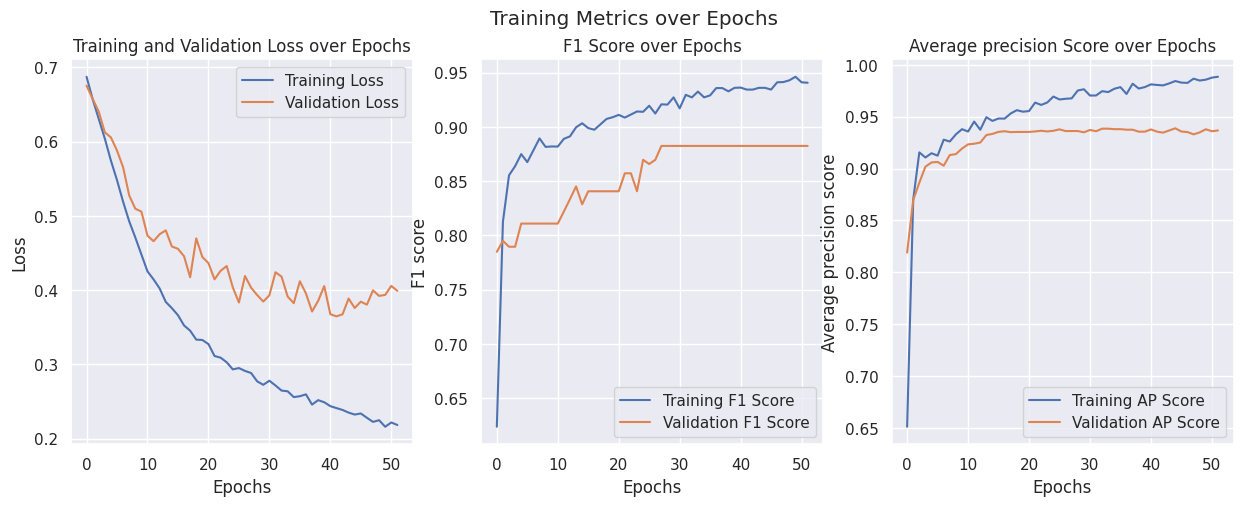

Saving...
Complete the process...


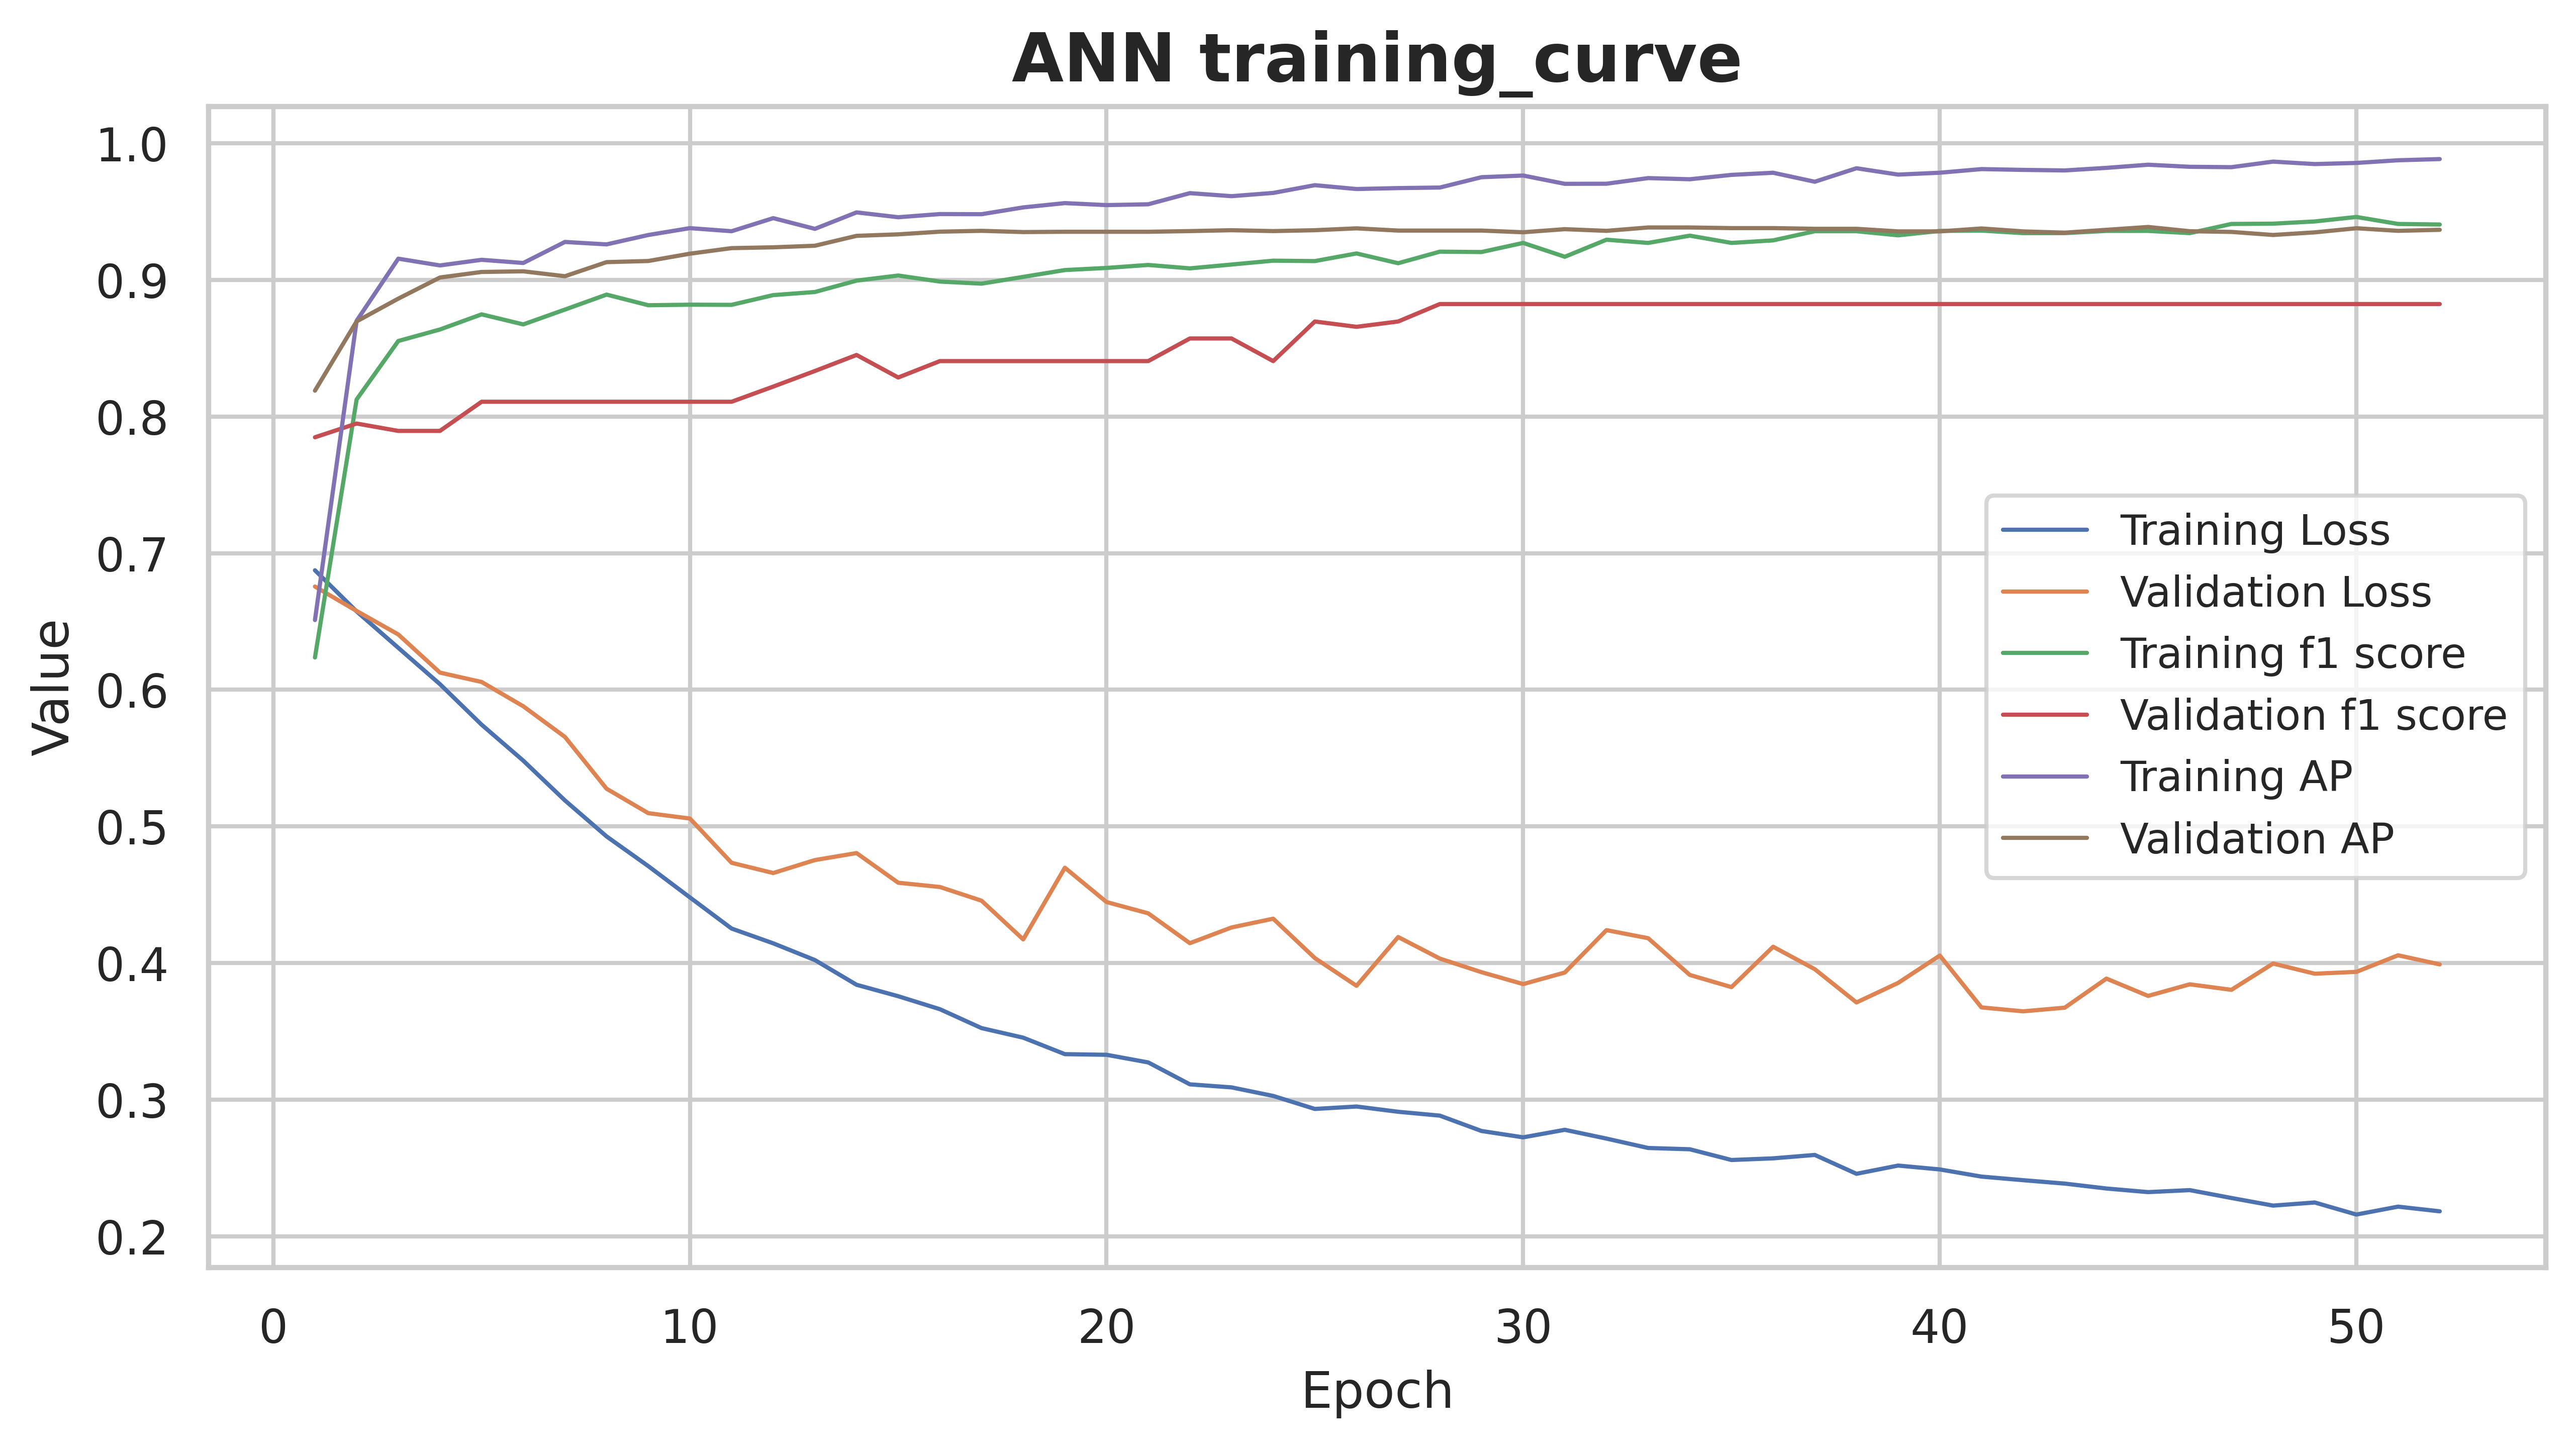

In [30]:
ann_training_curve(study.best_trial)

<ipython-input-8-cc25336a6f8a>:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Model', y=metric, data=df_melt, palette=my_colors, showmeans=True ,meanprops={"marker":"d",
<ipython-input-8-cc25336a6f8a>:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(xtick,ser[xtick]+ vertical_offset,ser[xtick],


Baseline vs. Tune: Custom statistical test, P_val:3.001e-05


<ipython-input-8-cc25336a6f8a>:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = AUC_internal.columns, fontsize = 12)


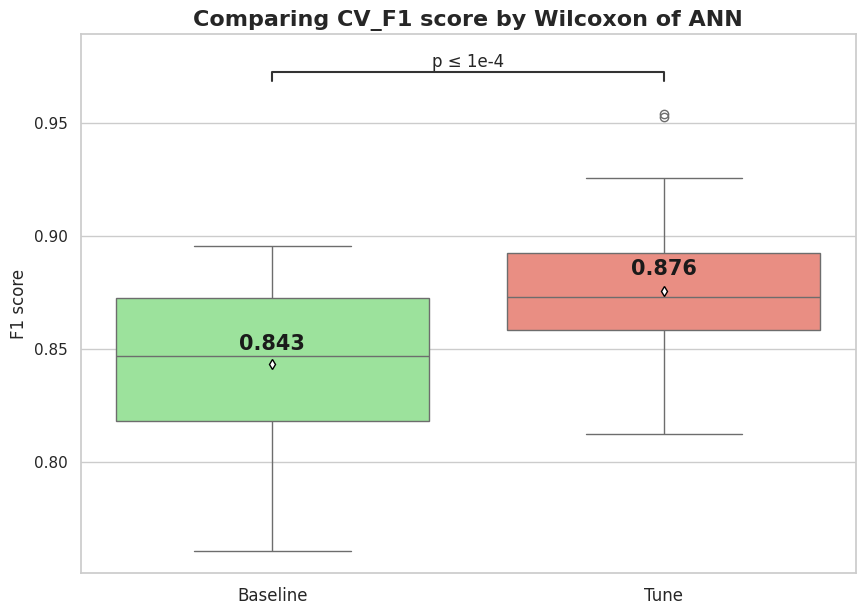

<ipython-input-8-cc25336a6f8a>:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Model', y=metric, data=df_melt, palette=my_colors, showmeans=True ,meanprops={"marker":"d",
<ipython-input-8-cc25336a6f8a>:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(xtick,ser[xtick]+ vertical_offset,ser[xtick],


Baseline vs. Tune: Custom statistical test, P_val:6.287e-05


<ipython-input-8-cc25336a6f8a>:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = AUC_internal.columns, fontsize = 12)


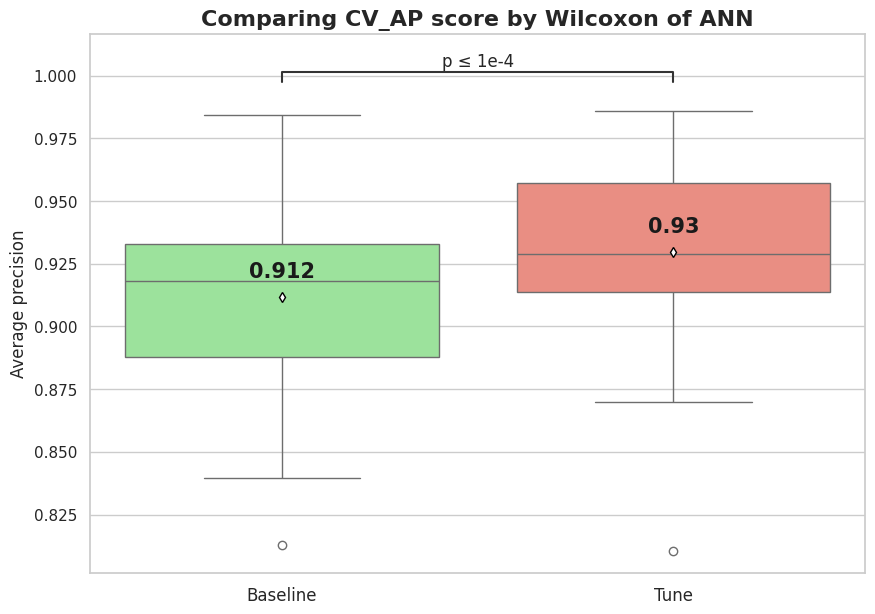

In [31]:
df_baseline = pd.read_csv("/content/drive/MyDrive/Thiazole project/ANN/ANN_cv_baseline.csv")
df_tune = pd.read_csv("/content/drive/MyDrive/Thiazole project/ANN/ANN_cv_best.csv")

#f1 score comparing
baseline_f1 = df_baseline["F1_record"]
tune_f1 = df_tune["F1_record"]
path_f1 = "/content/drive/MyDrive/Thiazole project/ANN/ANN_f1_compare_tune.png"
compare_opt_boxplot(baseline_f1, tune_f1, metric = "F1 score", fig_name="Comparing CV_F1 score by Wilcoxon of ANN", save_path = path_f1)

#average precision comparing
baseline_ap = df_baseline["AP_record"]
tune_ap = df_tune["AP_record"]
path_ap = "/content/drive/MyDrive/Thiazole project/ANN/ANN_ap_compare_tune.png"
compare_opt_boxplot(baseline_ap, tune_ap, metric = "Average precision", fig_name="Comparing CV_AP score by Wilcoxon of ANN", save_path = path_ap)